# CNN

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt

IMAGES_PATH = Path() / "pics" / "cnn"

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    
    if tight_layout:
        plt.tight_layout()
        
    plt.savefig(path, format=fig_extension, dpi=resolution)

##### Przygotowanie zestawu danych

In [16]:
import numpy as np
import tensorflow as tf

TRAIN_PATH = "GTSRB/Final_Training/Images";
TEST_PATH = "GTSRB/Final_Test/Images";

TRAIN_PATH_TENSOR = tf.constant(TRAIN_PATH, dtype=tf.string)
TEST_PATH_TENSOR = tf.constant(TEST_PATH, dtype=tf.string)

TRAIN_SIZE = 39209
TEST_SIZE = 12630

train_descriptor_files = [f"{TRAIN_PATH}/{i}/GT-{i:05d}.csv" for i in range(43)]
test_descriptor_file = f"{TEST_PATH}/GT-final_test.csv"

def resize_and_square_crop(img, size):
    smaller_dim = tf.minimum(tf.shape(img)[0], tf.shape(img)[1])
    larger_dim = tf.maximum(tf.shape(img)[0], tf.shape(img)[1])

    scaling_factor = size / smaller_dim
    new_larger_dim = tf.cast(tf.math.ceil(tf.cast(larger_dim, dtype=tf.float64) * scaling_factor), dtype=tf.int32)

    if tf.shape(img)[0] < tf.shape(img)[1]:
        new_dims = [size, new_larger_dim]
    else:
        new_dims = [new_larger_dim, size]

    img = tf.image.resize(img, new_dims, preserve_aspect_ratio=True, antialias=True)
    img = tf.image.crop_to_bounding_box(img, (tf.shape(img)[0] - size) // 2, (tf.shape(img)[1] - size) // 2, size, size)

    return img

def load_image(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=3)

    img  = resize_and_square_crop(img, 224)
    img = img / 255.0

    return img

def load_train_sample(desc_entry):
    fields = tf.io.decode_csv(
        desc_entry,
        field_delim=";",
        record_defaults=[tf.constant([], dtype=tf.string)] + [tf.constant([], dtype=tf.int32)] * 7
    )

    img_path = tf.strings.join([
            TRAIN_PATH_TENSOR,
            tf.strings.as_string(fields[7]),
            fields[0]
    ], separator="/")

    x = load_image(img_path)
    y = tf.one_hot(fields[7], 43)

    return x, y

def load_test_sample(desc_entry, gt_only=False):
    fields = tf.io.decode_csv(
        desc_entry,
        field_delim=";",
        record_defaults=[tf.constant([], dtype=tf.string)] + [tf.constant([], dtype=tf.int32)] * 7
    )

    if gt_only:
        return fields[7]

    img_path = tf.strings.join([
            TEST_PATH_TENSOR,
            fields[0]
    ], separator="/")

    x = load_image(img_path)
    y = tf.one_hot(fields[7], 43)

    return x, y

def load_gt_sample(desc_entry):
    return load_test_sample(desc_entry, gt_only=True)

def load_gtsrb_train_class(descriptor_file, ratio):
    dataset = tf.data.TextLineDataset(descriptor_file).skip(1)

    size = dataset.reduce(0, lambda x,_: x+1).numpy()

    dataset = dataset.shuffle(buffer_size=size)
    train_size = int(size * (1 - ratio))
    
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)

    return train_dataset, val_dataset

def gtsrb_dataset(type="train", batch_size=32, epochs=10, ratio=0.1, gt_only=False):
    if type == "train":
        train_set = tf.data.Dataset.from_tensor_slices(tf.constant([], dtype=tf.string))
        validation_set = tf.data.Dataset.from_tensor_slices(tf.constant([], dtype=tf.string))

        for descriptor_file in train_descriptor_files:
            ts, vs = load_gtsrb_train_class(descriptor_file, ratio)

            train_set = train_set.concatenate(ts)
            validation_set = validation_set.concatenate(vs)
        
        train_set = train_set.shuffle(buffer_size=10000)
        validation_set = validation_set.shuffle(buffer_size=10000)

        train_set = train_set.repeat(epochs)
        validation_set = validation_set.repeat(epochs)

        train_set = train_set.map(load_train_sample, num_parallel_calls=tf.data.AUTOTUNE)
        validation_set = validation_set.map(load_train_sample, num_parallel_calls=tf.data.AUTOTUNE)

        train_set = train_set.batch(batch_size)
        validation_set = validation_set.batch(batch_size)
        
        train_set = train_set.prefetch(buffer_size=100)
        validation_set = validation_set.prefetch(buffer_size=100)

        return train_set, validation_set
    if type == "test":
        dataset = tf.data.TextLineDataset([test_descriptor_file]).skip(1)

        if gt_only:
            dataset = dataset.map(load_gt_sample, num_parallel_calls=tf.data.AUTOTUNE)
            return dataset
        
        dataset = dataset.map(load_test_sample, num_parallel_calls=tf.data.AUTOTUNE)
    
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size=100)

        return dataset

In [2]:
import matplotlib.pyplot as plt

train_set, val_set = gtsrb_dataset(type="train", batch_size=32)

2024-08-19 21:52:23.397573: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


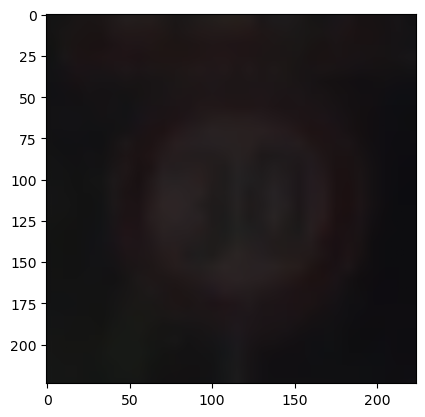

In [3]:
for line in train_set.take(1):
    plt.imshow(line[0][0].numpy())

In [24]:
for line in val_set.take(1):
    plt.imshow(line[0][0].numpy())

NameError: name 'val_set' is not defined

##### Jednostka rezydualna

In [13]:
from tensorflow import keras

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)

        self.activation = keras.activations.get(activation)

        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []

        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
                keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs

        for layer in self.main_layers:
            Z = layer(Z)

        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)

        return self.activation(Z + skip_Z)

##### Model: ResNet-18

In [ ]:
model = keras.models.Sequential()

model.add(keras.Input(shape=(224, 224, 3)))

##### Model: ResNet-34

In [15]:
model = keras.models.Sequential()

model.add(keras.Input(shape=[224, 224, 3]))
model.add(keras.layers.Conv2D(64, 7, strides=2, padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))

prev_filters = 64

for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2

    model.add(ResidualUnit(filters, strides=strides))

    prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(43, activation="softmax"))


In [20]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 112, 112, 64)   │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_16 (ResidualUnit) │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_17 (ResidualUnit) │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_18 (ResidualUnit) │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_19 (ResidualUnit) │ (None, 28, 28, 128)    │       230,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_20 (ResidualUnit) │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_21 (ResidualUnit) │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_22 (ResidualUnit) │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_23 (ResidualUnit) │ (None, 14, 14, 256)    │       920,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_24 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_25 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_26 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_27 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_28 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_29 (ResidualUnit) │ (None, 7, 7, 512)      │     3,676,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_30 (ResidualUnit) │ (None, 7, 7, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_31 (ResidualUnit) │ (None, 7, 7, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,323,755 (81.34 MB)

 Trainable params: 21,306,731 (81.28 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [21]:
import math

batch_size = 32
epochs = 30

train_set, val_set = gtsrb_dataset(type="train", batch_size=batch_size, epochs=epochs, ratio=0.1)

early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy", restore_best_weights=True, patience=10)
reduce_lr_plateau = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=0.0001)
checkpoint = keras.callbacks.ModelCheckpoint("resnet34.keras", save_best_only=True, monitor="val_accuracy", mode="max")

history = model.fit(
    train_set,                  steps_per_epoch=math.ceil((TRAIN_SIZE * 0.9) / batch_size),
    validation_data=val_set,    validation_steps=math.ceil((TRAIN_SIZE * 0.1) / batch_size),
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr_plateau, checkpoint]
)

Epoch 1/30
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 242s 193ms/step - accuracy: 0.3098 - loss: 2.1630 - val_accuracy: 0.5813 - val_loss: 1.3126 - learning_rate: 0.0010
Epoch 2/30
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 208s 188ms/step - accuracy: 0.8929 - loss: 0.3529 - val_accuracy: 0.9591 - val_loss: 0.1420 - learning_rate: 0.0010
Epoch 3/30
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 207s 188ms/step - accuracy: 0.9785 - loss: 0.0698 - val_accuracy: 0.9680 - val_loss: 0.1080 - learning_rate: 0.0010
Epoch 4/30
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 210s 190ms/step - accuracy: 0.9851 - loss: 0.0490 - val_accuracy: 0.9685 - val_loss: 0.1060 - learning_rate: 0.0010
Epoch 5/30
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 209s 189ms/step - accuracy: 0.9876 - loss: 0.0409 - val_accuracy: 0.9647 - val_loss: 0.1046 - learning_rate: 0.0010
Epoch 6/30
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 210s 191ms/step - accuracy: 0.9853 - loss: 0.0522 - val_accuracy: 0.9837 - val_loss: 0.0553 - learning_rate: 0.0010
Epoch 7/30
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 210s 191ms

In [23]:
model.evaluate(gtsrb_dataset(type="test", batch_size=32))

395/395 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.9793 - loss: 0.0759


/home/pauca/miniforge3/envs/ml/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


[0.07819639146327972, 0.9789390563964844]

##### Model: ResNet-50

In [2]:
from tensorflow import keras

model = keras.applications.ResNet50(weights=None, input_shape=(224, 224, 3), classes=43)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,675,819 (90.32 MB)

 Trainable params: 23,622,699 (90.11 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [3]:
import math

batch_size = 32
epochs = 30

train_set, val_set = gtsrb_dataset(type="train", batch_size=batch_size, epochs=epochs, ratio=0.1)

early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy", restore_best_weights=True, patience=10)
reduce_lr_plateau = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=0.0001)
checkpoint = keras.callbacks.ModelCheckpoint("resnet50.keras", save_best_only=True, monitor="val_accuracy", mode="max")

history = model.fit(
    train_set,                  steps_per_epoch=math.ceil((TRAIN_SIZE * 0.9) / batch_size),
    validation_data=val_set,    validation_steps=math.ceil((TRAIN_SIZE * 0.1) / batch_size),
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr_plateau, checkpoint]
)

Epoch 1/30


I0000 00:00:1724127594.555038    3576 service.cc:146] XLA service 0x727fcc005020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724127594.555145    3576 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-08-20 06:19:56.926155: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-20 06:20:00.003660: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-08-20 06:20:05.010825: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-20 06:20:05.010865: W external/local_tsl/tsl/framework/bfc_allocator.cc:291

1103/1103 ━━━━━━━━━━━━━━━━━━━━ 377s 296ms/step - accuracy: 0.2126 - loss: 2.6136 - val_accuracy: 0.3249 - val_loss: 2.1579 - learning_rate: 0.0010
Epoch 2/30
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 324s 294ms/step - accuracy: 0.6461 - loss: 1.0329 - val_accuracy: 0.9111 - val_loss: 0.2835 - learning_rate: 0.0010
Epoch 3/30
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 325s 294ms/step - accuracy: 0.9571 - loss: 0.1384 - val_accuracy: 0.9426 - val_loss: 0.1889 - learning_rate: 0.0010
Epoch 4/30
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 325s 294ms/step - accuracy: 0.9793 - loss: 0.0688 - val_accuracy: 0.9662 - val_loss: 0.1111 - learning_rate: 0.0010
Epoch 5/30
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 325s 294ms/step - accuracy: 0.9828 - loss: 0.0567 - val_accuracy: 0.9850 - val_loss: 0.0441 - learning_rate: 0.0010
Epoch 6/30
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 323s 293ms/step - accuracy: 0.9879 - loss: 0.0424 - val_accuracy: 0.9713 - val_loss: 0.0858 - learning_rate: 0.0010
Epoch 7/30
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 325s 295ms/step - acc

In [6]:
from tensorflow import keras

model = keras.models.load_model("resnet50.keras")

keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

In [24]:
from tensorflow import keras

model = keras.models.load_model("resnet50.keras")

model.evaluate(gtsrb_dataset(type="test", batch_size=32))

395/395 ━━━━━━━━━━━━━━━━━━━━ 40s 86ms/step - accuracy: 0.9831 - loss: 0.0587


[0.06017566844820976, 0.9840855002403259]

In [4]:
from tensorflow import keras
from sklearn.metrics import confusion_matrix

model = keras.models.load_model("resnet50.keras")
y_pred = model.predict(gtsrb_dataset(type="test", batch_size=32)).argmax(axis=1)

2024-09-02 15:38:32.272958: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 3356006400 bytes after encountering the first element of size 33560064 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
I0000 00:00:1725284315.467841   29726 service.cc:145] XLA service 0x765878045520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725284315.467903   29726 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-09-02 15:38:35.566659: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-02 15:38:35.934069: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


      3/Unknown 7s 63ms/step

I0000 00:00:1725284319.221400   29726 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


395/395 ━━━━━━━━━━━━━━━━━━━━ 41s 86ms/step


2024-09-02 15:39:13.092061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/pauca/miniforge3/envs/ml_tf/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [28]:
y_gt = list(gtsrb_dataset(type="test", gt_only=True).as_numpy_iterator())

2024-09-02 15:57:52.203636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [85]:
confm = confusion_matrix(y_gt, y_pred, normalize="pred").round(2)

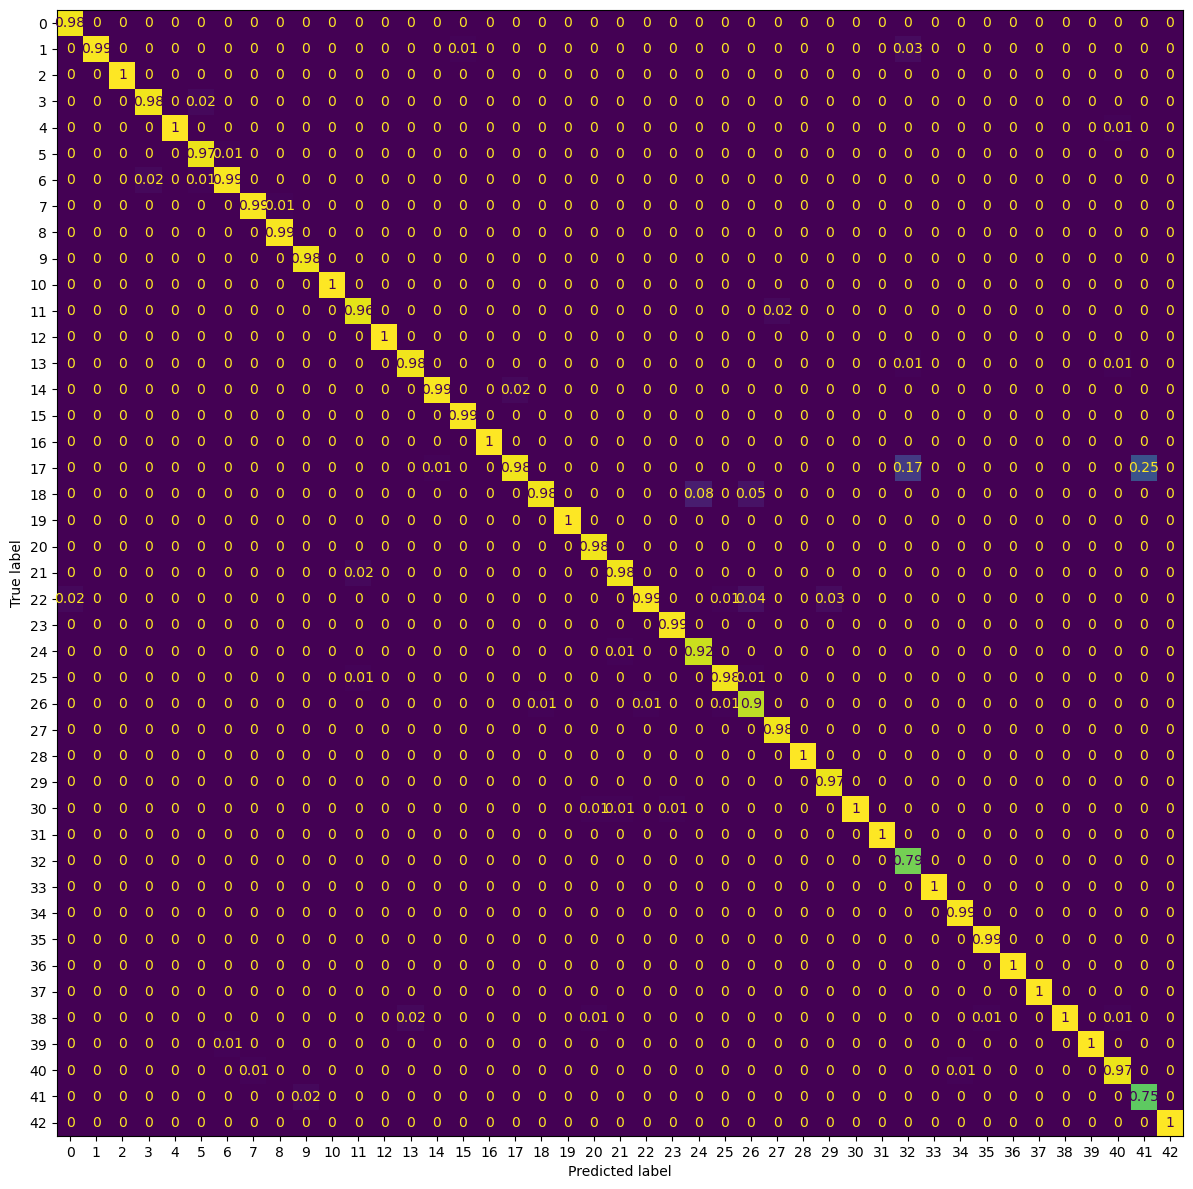

In [93]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(12, 12))

cmd = ConfusionMatrixDisplay(confusion_matrix=confm, display_labels=range(43))
cmd.plot(ax=ax, colorbar=False)

save_fig("resnet50_confusion_matrix")
plt.show()

##### Model ResNet-50: wagi ImageNet

In [33]:
from tensorflow import keras

resnet_core = keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

In [9]:
len(resnet_core.layers)

175

In [35]:
model = keras.models.Sequential()

model.add(resnet_core)
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Dense(43, activation="softmax"))

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [4]:
import math

batch_size = 32
epochs = 10

train_set, val_set = gtsrb_dataset(type="train", batch_size=batch_size, epochs=epochs, ratio=0.1)

early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy", restore_best_weights=True, patience=5)
reduce_lr_plateau = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=0.0001)
checkpoint = keras.callbacks.ModelCheckpoint("resnet50_from_imagenet-core_unlocked.keras", save_best_only=True, monitor="val_accuracy", mode="max")

history = model.fit(
    train_set,                  steps_per_epoch=math.ceil((TRAIN_SIZE * 0.9) / batch_size),
    validation_data=val_set,    validation_steps=math.ceil((TRAIN_SIZE * 0.1) / batch_size),
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr_plateau, checkpoint]
)

Epoch 1/10


2024-08-28 16:22:36.193855: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 3356006400 bytes after encountering the first element of size 33560064 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
I0000 00:00:1724854956.236063    5793 service.cc:145] XLA service 0x7d96fc003180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724854956.236160    5793 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-08-28 16:22:38.644482: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-28 16:22:41.281987: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-08-28 16:22:46.358913: W external/local_tsl/ts

1103/1103 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9017 - loss: 0.3846

2024-08-28 16:28:16.074289: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1927321600 bytes after encountering the first element of size 19273216 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1103/1103 ━━━━━━━━━━━━━━━━━━━━ 378s 299ms/step - accuracy: 0.9017 - loss: 0.3845 - val_accuracy: 0.9611 - val_loss: 0.1432 - learning_rate: 0.0010
Epoch 2/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 323s 293ms/step - accuracy: 0.9901 - loss: 0.0368 - val_accuracy: 0.9477 - val_loss: 0.3689 - learning_rate: 0.0010
Epoch 3/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 325s 295ms/step - accuracy: 0.9899 - loss: 0.0363 - val_accuracy: 0.9738 - val_loss: 0.0985 - learning_rate: 0.0010
Epoch 4/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 325s 295ms/step - accuracy: 0.9932 - loss: 0.0233 - val_accuracy: 0.9934 - val_loss: 0.0230 - learning_rate: 0.0010
Epoch 5/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 325s 295ms/step - accuracy: 0.9943 - loss: 0.0227 - val_accuracy: 0.9972 - val_loss: 0.0105 - learning_rate: 0.0010
Epoch 6/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 325s 295ms/step - accuracy: 0.9963 - loss: 0.0139 - val_accuracy: 0.9990 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 7/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 324s 293ms/step - acc

2024-08-28 17:17:05.655544: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-28 17:17:06.132470: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-28 17:17:06.498105: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1101/1103 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9991 - loss: 0.0029

2024-08-28 17:17:19.309734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-28 17:17:19.310333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/home/pauca/miniforge3/envs/ml_tf/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-08-28 17:17:31.307204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-28 17:17:31.307443: W tensorflow/core/framework/local_rendezvous.cc:404

1103/1103 ━━━━━━━━━━━━━━━━━━━━ 346s 314ms/step - accuracy: 0.9991 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 9.3824e-05 - learning_rate: 2.0000e-04


In [5]:
model.evaluate(gtsrb_dataset(type="test", batch_size=32))

      1/Unknown 0s 272ms/step - accuracy: 1.0000 - loss: 0.0056

2024-08-28 18:23:13.754550: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 3356006400 bytes after encountering the first element of size 33560064 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


395/395 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.9889 - loss: 0.0392


2024-08-28 18:23:48.987635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-28 18:23:48.987990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/pauca/miniforge3/envs/ml_tf/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


[0.04257286339998245, 0.987569272518158]

##### ResNet50 ImageNet - zablokowany rdzeń

In [3]:
from tensorflow import keras

resnet_core = keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

for layer in resnet_core.layers:
    layer.trainable = False

In [4]:
model = keras.models.Sequential()

model.add(resnet_core)
model.add(keras.layers.GlobalAvgPool2D())

model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(43, activation="softmax"))

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [5]:
import math

batch_size = 32
epochs = 10

train_set, val_set = gtsrb_dataset(type="train", batch_size=batch_size, epochs=epochs, ratio=0.1)

early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy", restore_best_weights=True, patience=5)
reduce_lr_plateau = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=0.0001)
checkpoint = keras.callbacks.ModelCheckpoint("resnet50_from_imagenet-core_locked.keras", save_best_only=True, monitor="val_accuracy", mode="max")

history = model.fit(
    train_set,                  steps_per_epoch=math.ceil((TRAIN_SIZE * 0.9) / batch_size),
    validation_data=val_set,    validation_steps=math.ceil((TRAIN_SIZE * 0.1) / batch_size),
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr_plateau, checkpoint]
)

Epoch 1/10


2024-08-29 00:11:11.340610: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 3356006400 bytes after encountering the first element of size 33560064 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
I0000 00:00:1724883071.392110   32839 service.cc:145] XLA service 0x77f864006570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724883071.392160   32839 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-08-29 00:11:11.918849: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-29 00:11:13.864679: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


   2/1103 ━━━━━━━━━━━━━━━━━━━━ 1:32 84ms/step - accuracy: 0.0312 - loss: 4.2944      

I0000 00:00:1724883077.488840   32839 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1103/1103 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.1673 - loss: 2.5790

2024-08-29 00:12:51.028220: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1927321600 bytes after encountering the first element of size 19273216 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1103/1103 ━━━━━━━━━━━━━━━━━━━━ 121s 99ms/step - accuracy: 0.1673 - loss: 2.5793 - val_accuracy: 0.0749 - val_loss: 3.6114 - learning_rate: 0.0010
Epoch 2/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 102s 92ms/step - accuracy: 0.1965 - loss: 2.5055 - val_accuracy: 0.0930 - val_loss: 3.4477 - learning_rate: 0.0010
Epoch 3/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 102s 92ms/step - accuracy: 0.2338 - loss: 2.3729 - val_accuracy: 0.1141 - val_loss: 3.3683 - learning_rate: 0.0010
Epoch 4/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 102s 92ms/step - accuracy: 0.2618 - loss: 2.2822 - val_accuracy: 0.1463 - val_loss: 3.1448 - learning_rate: 0.0010
Epoch 5/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 102s 92ms/step - accuracy: 0.2726 - loss: 2.2280 - val_accuracy: 0.1631 - val_loss: 3.1171 - learning_rate: 0.0010
Epoch 6/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 102s 93ms/step - accuracy: 0.2956 - loss: 2.1708 - val_accuracy: 0.1931 - val_loss: 2.9259 - learning_rate: 0.0010
Epoch 7/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 102s 92ms/step - accuracy: 

2024-08-29 00:28:13.726942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-29 00:28:13.727146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/pauca/miniforge3/envs/ml_tf/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-08-29 00:28:25.503193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-29 00:28:25.503432: W tensorflow/core/framework/local_rendezvous.cc:404

1103/1103 ━━━━━━━━━━━━━━━━━━━━ 107s 97ms/step - accuracy: 0.3332 - loss: 2.0204 - val_accuracy: 0.2361 - val_loss: 2.7717 - learning_rate: 0.0010
